# Unit11_Polynomial_Regression | 多項式回歸：催化反應產率建模

本 Notebook 演示如何使用 **多項式回歸 (Polynomial Regression)** 建立催化反應器的溫度-產率關係模型。

## 目標
- 生成模擬的反應器溫度-產率資料
- 使用不同次數的多項式回歸擬合資料
- 比較不同次數模型的性能
- 使用交叉驗證選擇最佳多項式次數
- 視覺化模型擬合效果和殘差分析
- 預測最佳操作溫度

**案例背景**：某催化反應的產率與反應溫度呈現拋物線關係，存在最佳溫度點。

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit11_Polynomial_Regression'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
  
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit11'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  FIG_DIR = OUTPUT_DIR / 'figs'

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Polynomial_Regression
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Polynomial_Regression\figs


---
## 1. 載入相關套件

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# sklearn 相關套件
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    validation_curve,
    learning_curve
)
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# 設定
np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 2. 資料生成

模擬催化反應器的實驗資料：
- **自變數**：反應溫度 (Temperature, °C)
- **因變數**：產率 (Yield, %)
- **真實關係**：二次函數（拋物線），最佳溫度為 200°C
- **雜訊**：測量誤差（常態分佈）

In [3]:
# 生成溫度資料點
n_samples = 20
temperature = np.linspace(150, 250, n_samples)

# 真實關係：拋物線（最佳溫度 200°C，最大產率 92%）
true_yield = -0.005 * (temperature - 200)**2 + 92

# 加入測量雜訊
noise = np.random.normal(0, 2, size=n_samples)
measured_yield = true_yield + noise

# 資料整理
X = temperature.reshape(-1, 1)  # sklearn 需要 2D 陣列
y = measured_yield

print(f"資料形狀：")
print(f"  X (溫度): {X.shape}")
print(f"  y (產率): {y.shape}")
print(f"\n溫度範圍: {X.min():.1f} - {X.max():.1f} °C")
print(f"產率範圍: {y.min():.2f} - {y.max():.2f} %")

資料形狀：
  X (溫度): (20, 1)
  y (產率): (20,)

溫度範圍: 150.0 - 250.0 °C
產率範圍: 76.68 - 93.46 %


### 2.1 視覺化原始資料

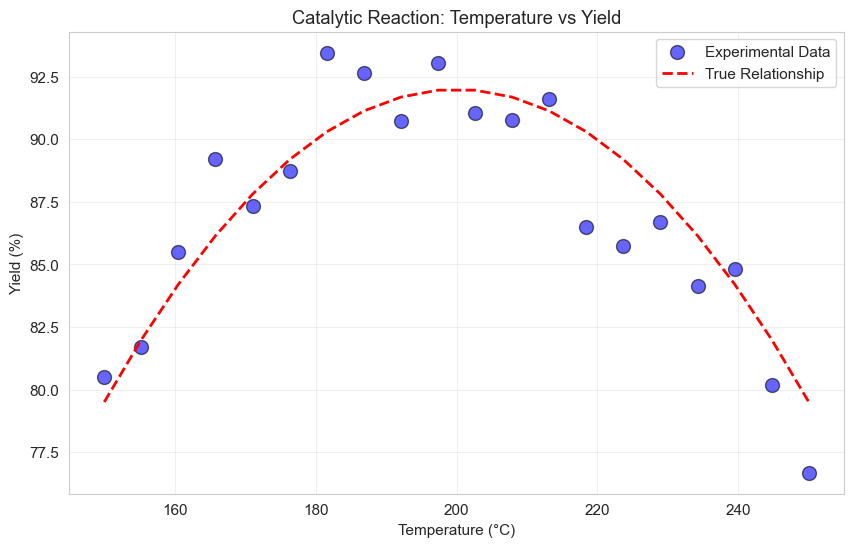

✓ 圖檔已儲存


In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(temperature, measured_yield, color='blue', s=100, alpha=0.6, 
            edgecolors='black', label='Experimental Data')
plt.plot(temperature, true_yield, 'r--', linewidth=2, label='True Relationship')
plt.xlabel('Temperature (°C)')
plt.ylabel('Yield (%)')
plt.title('Catalytic Reaction: Temperature vs Yield')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(FIG_DIR / '01_raw_data.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖檔已儲存")

### 2.2 資料分割

In [5]:
# 分割訓練集與測試集 (70% 訓練, 30% 測試)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"訓練集樣本數: {len(X_train)}")
print(f"測試集樣本數: {len(X_test)}")

訓練集樣本數: 14
測試集樣本數: 6


---
## 3. 建立多項式回歸模型

我們將比較不同次數（degree 1 到 5）的多項式回歸模型。

### 3.1 訓練多個模型

In [6]:
# 定義要測試的多項式次數
degrees = [1, 2, 3, 4, 5]

# 儲存模型和結果
models = {}
predictions = {}
results = []

for d in degrees:
    # 建立 Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=d)),
        ('regressor', LinearRegression())
    ])
    
    # 訓練模型
    pipeline.fit(X_train, y_train)
    
    # 預測
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    # 儲存
    models[d] = pipeline
    predictions[d] = {
        'train': y_pred_train,
        'test': y_pred_test
    }
    
    # 評估
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # 記錄結果
    results.append({
        'Degree': d,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae
    })

# 轉換為 DataFrame
results_df = pd.DataFrame(results)
print("\n模型評估結果：")
print(results_df.to_string(index=False))


模型評估結果：
 Degree  Train_R2   Test_R2  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE
      1  0.370474 -2.834308    3.827498   7.113712   3.291213  5.062721
      2  0.917228  0.644631    1.387873   2.165672   1.181382  1.990701
      3  0.936595  0.627815    1.214699   2.216319   0.992006  2.035326
      4  0.936635  0.618105    1.214322   2.245043   0.985845  2.054081
      5  0.947116 -0.208394    1.109352   3.993531   0.846160  3.470591


### 3.2 視覺化不同次數的擬合效果

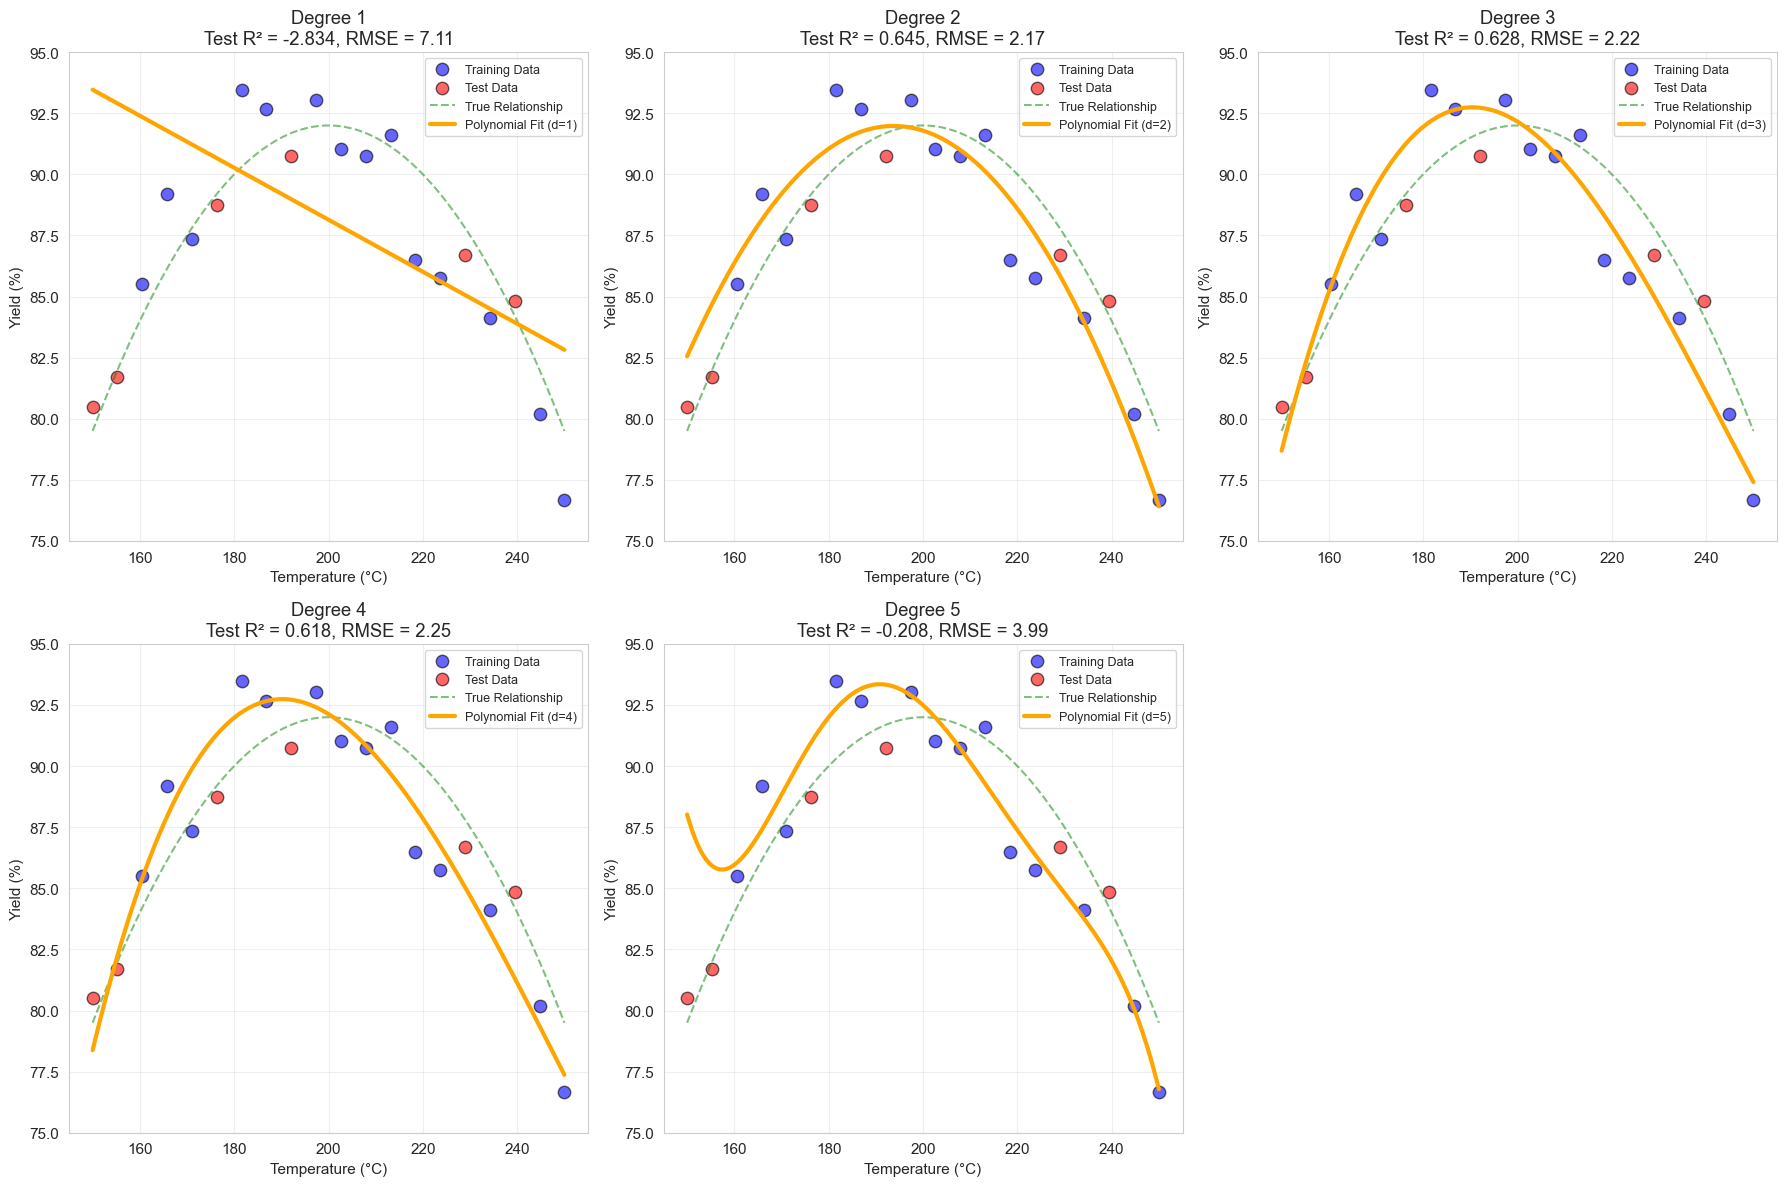

✓ 圖檔已儲存


In [7]:
# 生成平滑曲線用的資料點
X_plot = np.linspace(150, 250, 200).reshape(-1, 1)

# 繪製多個子圖
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, d in enumerate(degrees):
    ax = axes[idx]
    
    # 預測平滑曲線
    y_plot = models[d].predict(X_plot)
    
    # 繪製資料點
    ax.scatter(X_train, y_train, color='blue', alpha=0.6, s=80, 
               edgecolors='black', label='Training Data')
    ax.scatter(X_test, y_test, color='red', alpha=0.6, s=80, 
               edgecolors='black', label='Test Data')
    
    # 繪製真實關係
    ax.plot(X_plot, -0.005 * (X_plot.flatten() - 200)**2 + 92, 
            'g--', linewidth=1.5, alpha=0.5, label='True Relationship')
    
    # 繪製擬合曲線
    ax.plot(X_plot, y_plot, color='orange', linewidth=3, 
            label=f'Polynomial Fit (d={d})')
    
    # 標記
    test_r2 = results_df.loc[results_df['Degree']==d, 'Test_R2'].values[0]
    test_rmse = results_df.loc[results_df['Degree']==d, 'Test_RMSE'].values[0]
    
    ax.set_title(f'Degree {d}\nTest R² = {test_r2:.3f}, RMSE = {test_rmse:.2f}')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Yield (%)')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([75, 95])

# 移除多餘的子圖
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig(FIG_DIR / '02_polynomial_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖檔已儲存")

### 3.3 模型性能比較

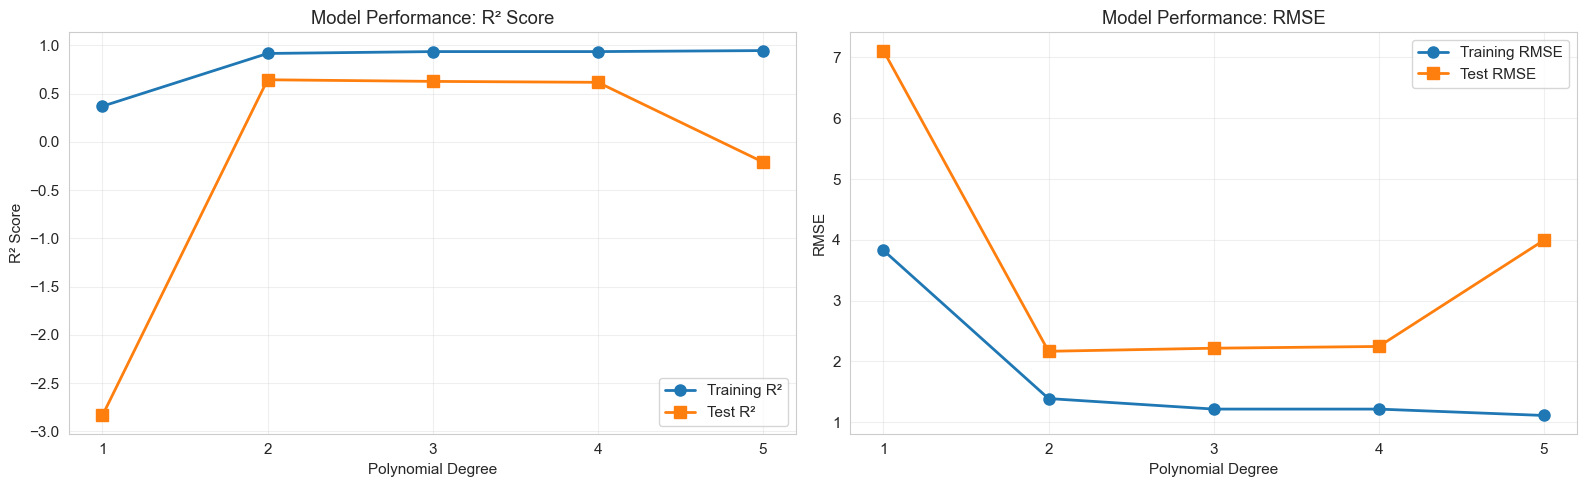

✓ 圖檔已儲存


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# R² 比較
axes[0].plot(results_df['Degree'], results_df['Train_R2'], 
             'o-', linewidth=2, markersize=8, label='Training R²')
axes[0].plot(results_df['Degree'], results_df['Test_R2'], 
             's-', linewidth=2, markersize=8, label='Test R²')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance: R² Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(degrees)

# RMSE 比較
axes[1].plot(results_df['Degree'], results_df['Train_RMSE'], 
             'o-', linewidth=2, markersize=8, label='Training RMSE')
axes[1].plot(results_df['Degree'], results_df['Test_RMSE'], 
             's-', linewidth=2, markersize=8, label='Test RMSE')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Model Performance: RMSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(degrees)

plt.tight_layout()
plt.savefig(FIG_DIR / '03_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖檔已儲存")

---
## 4. 交叉驗證選擇最佳次數

In [9]:
# 使用 5 折交叉驗證
cv_scores = {}
cv_std = {}

print("\n交叉驗證結果：")
print("-" * 50)

for d in range(1, 8):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=d)),
        ('regressor', LinearRegression())
    ])
    
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    cv_scores[d] = scores.mean()
    cv_std[d] = scores.std()
    
    print(f"Degree {d}: CV R² = {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# 找出最佳次數
best_degree = max(cv_scores, key=cv_scores.get)
print("\n" + "="*50)
print(f"最佳多項式次數: {best_degree}")
print(f"最佳 CV R²: {cv_scores[best_degree]:.4f}")
print("="*50)


交叉驗證結果：
--------------------------------------------------
Degree 1: CV R² = -11.1263 (+/- 22.4025)
Degree 2: CV R² = 0.2634 (+/- 0.6938)
Degree 3: CV R² = 0.2799 (+/- 0.6103)
Degree 4: CV R² = -6.8913 (+/- 24.9066)
Degree 5: CV R² = -9.5883 (+/- 38.6240)
Degree 6: CV R² = -124.9302 (+/- 398.5878)
Degree 7: CV R² = -370.5391 (+/- 1224.1502)

最佳多項式次數: 3
最佳 CV R²: 0.2799


### 4.1 視覺化交叉驗證結果

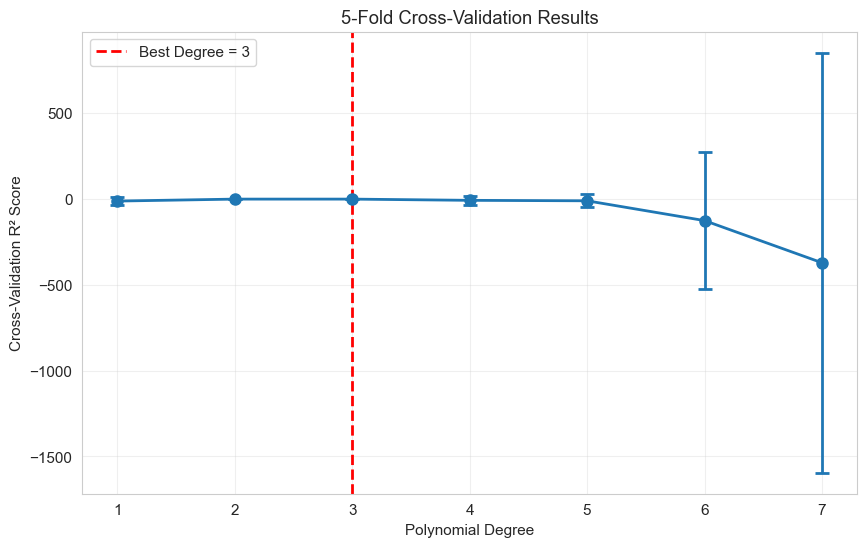

✓ 圖檔已儲存


In [10]:
degrees_cv = list(cv_scores.keys())
means = [cv_scores[d] for d in degrees_cv]
stds = [cv_std[d] for d in degrees_cv]

plt.figure(figsize=(10, 6))
plt.errorbar(degrees_cv, means, yerr=np.array(stds)*2, 
             fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2)
plt.axvline(x=best_degree, color='red', linestyle='--', linewidth=2, 
            label=f'Best Degree = {best_degree}')
plt.xlabel('Polynomial Degree')
plt.ylabel('Cross-Validation R² Score')
plt.title('5-Fold Cross-Validation Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(degrees_cv)
plt.savefig(FIG_DIR / '04_cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖檔已儲存")

---
## 5. 驗證曲線分析

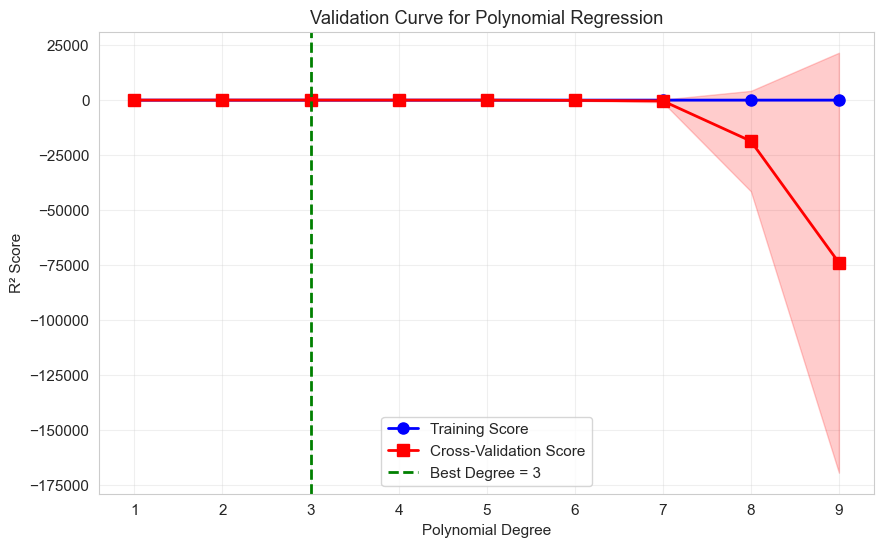

✓ 圖檔已儲存


In [11]:
# 計算驗證曲線
param_range = np.arange(1, 10)
train_scores, test_scores = validation_curve(
    Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('regressor', LinearRegression())
    ]),
    X, y,
    param_name='poly__degree',
    param_range=param_range,
    cv=5,
    scoring='r2'
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training Score', 
         color='blue', marker='o', linewidth=2, markersize=8)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='blue')

plt.plot(param_range, test_mean, label='Cross-Validation Score', 
         color='red', marker='s', linewidth=2, markersize=8)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, 
                 alpha=0.2, color='red')

plt.axvline(x=best_degree, color='green', linestyle='--', linewidth=2, 
            label=f'Best Degree = {best_degree}')

plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('Validation Curve for Polynomial Regression')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(param_range)
plt.savefig(FIG_DIR / '05_validation_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖檔已儲存")

---
## 6. 最終模型與預測

### 6.1 使用最佳次數建立模型

In [12]:
# 使用最佳次數建立最終模型（使用全部資料訓練）
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('regressor', LinearRegression())
])

final_model.fit(X, y)

# 模型係數
poly_features = final_model.named_steps['poly'].get_feature_names_out(['Temperature'])
coefficients = final_model.named_steps['regressor'].coef_
intercept = final_model.named_steps['regressor'].intercept_

print("\n最終模型係數：")
print("-" * 50)
print(f"截距 (Intercept): {intercept:.4f}")
for feat, coef in zip(poly_features, coefficients):
    if feat != '1':  # 跳過截距項（已在上面顯示）
        print(f"{feat:20s}: {coef:10.4f}")


最終模型係數：
--------------------------------------------------
截距 (Intercept): 91.7797
Temperature         :    -2.1684
Temperature^2       :    -4.7275
Temperature^3       :     0.5686


### 6.2 預測新溫度下的產率

In [13]:
# 預測特定溫度點
new_temperatures = np.array([170, 185, 195, 200, 205, 215, 230]).reshape(-1, 1)
predicted_yields = final_model.predict(new_temperatures)

print("\n預測結果：")
print("-" * 50)
prediction_df = pd.DataFrame({
    'Temperature (°C)': new_temperatures.flatten(),
    'Predicted Yield (%)': predicted_yields
})
print(prediction_df.to_string(index=False))


預測結果：
--------------------------------------------------
 Temperature (°C)  Predicted Yield (%)
              170            88.754393
              185            91.627876
              195            92.006054
              200            91.779672
              205            91.296653
              215            89.621732
              230            85.566002


### 6.3 尋找最佳操作溫度

In [14]:
# 在溫度範圍內密集採樣
T_range = np.linspace(150, 250, 500).reshape(-1, 1)
Y_pred = final_model.predict(T_range)

# 找出最大產率點
optimal_idx = np.argmax(Y_pred)
optimal_temp = T_range[optimal_idx][0]
optimal_yield = Y_pred[optimal_idx]

print("\n" + "="*50)
print("最佳操作條件：")
print("="*50)
print(f"最佳溫度: {optimal_temp:.2f} °C")
print(f"預測最大產率: {optimal_yield:.2f} %")
print("="*50)


最佳操作條件：
最佳溫度: 193.29 °C
預測最大產率: 92.02 %


### 6.4 視覺化最終模型

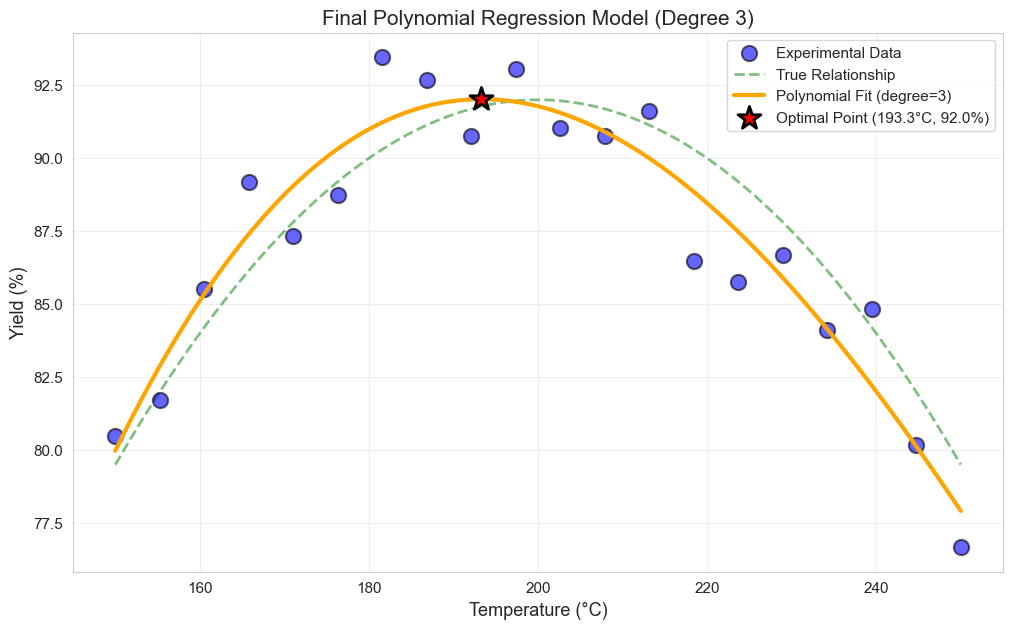

✓ 圖檔已儲存


In [15]:
plt.figure(figsize=(12, 7))

# 實驗資料點
plt.scatter(X, y, color='blue', s=120, alpha=0.6, 
            edgecolors='black', linewidths=1.5, label='Experimental Data', zorder=3)

# 真實關係
plt.plot(T_range, -0.005 * (T_range.flatten() - 200)**2 + 92, 
         'g--', linewidth=2, alpha=0.5, label='True Relationship', zorder=2)

# 模型預測曲線
plt.plot(T_range, Y_pred, color='orange', linewidth=3, 
         label=f'Polynomial Fit (degree={best_degree})', zorder=4)

# 標記最佳點
plt.scatter([optimal_temp], [optimal_yield], color='red', s=300, 
            marker='*', edgecolors='black', linewidths=2, 
            label=f'Optimal Point ({optimal_temp:.1f}°C, {optimal_yield:.1f}%)', 
            zorder=5)

plt.xlabel('Temperature (°C)', fontsize=13)
plt.ylabel('Yield (%)', fontsize=13)
plt.title(f'Final Polynomial Regression Model (Degree {best_degree})', fontsize=15)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.savefig(FIG_DIR / '06_final_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖檔已儲存")

---
## 7. 殘差分析

In [16]:
# 計算殘差
y_pred_final = final_model.predict(X)
residuals = y - y_pred_final

# 殘差統計
print("\n殘差統計：")
print("-" * 50)
print(f"均值 (Mean):     {residuals.mean():.4f}")
print(f"標準差 (Std):     {residuals.std():.4f}")
print(f"最大值 (Max):     {residuals.max():.4f}")
print(f"最小值 (Min):     {residuals.min():.4f}")
print(f"絕對值平均 (MAE): {np.abs(residuals).mean():.4f}")


殘差統計：
--------------------------------------------------
均值 (Mean):     -0.0000
標準差 (Std):     1.4064
最大值 (Max):     2.6248
最小值 (Min):     -2.3722
絕對值平均 (MAE): 1.1772


### 7.1 視覺化殘差

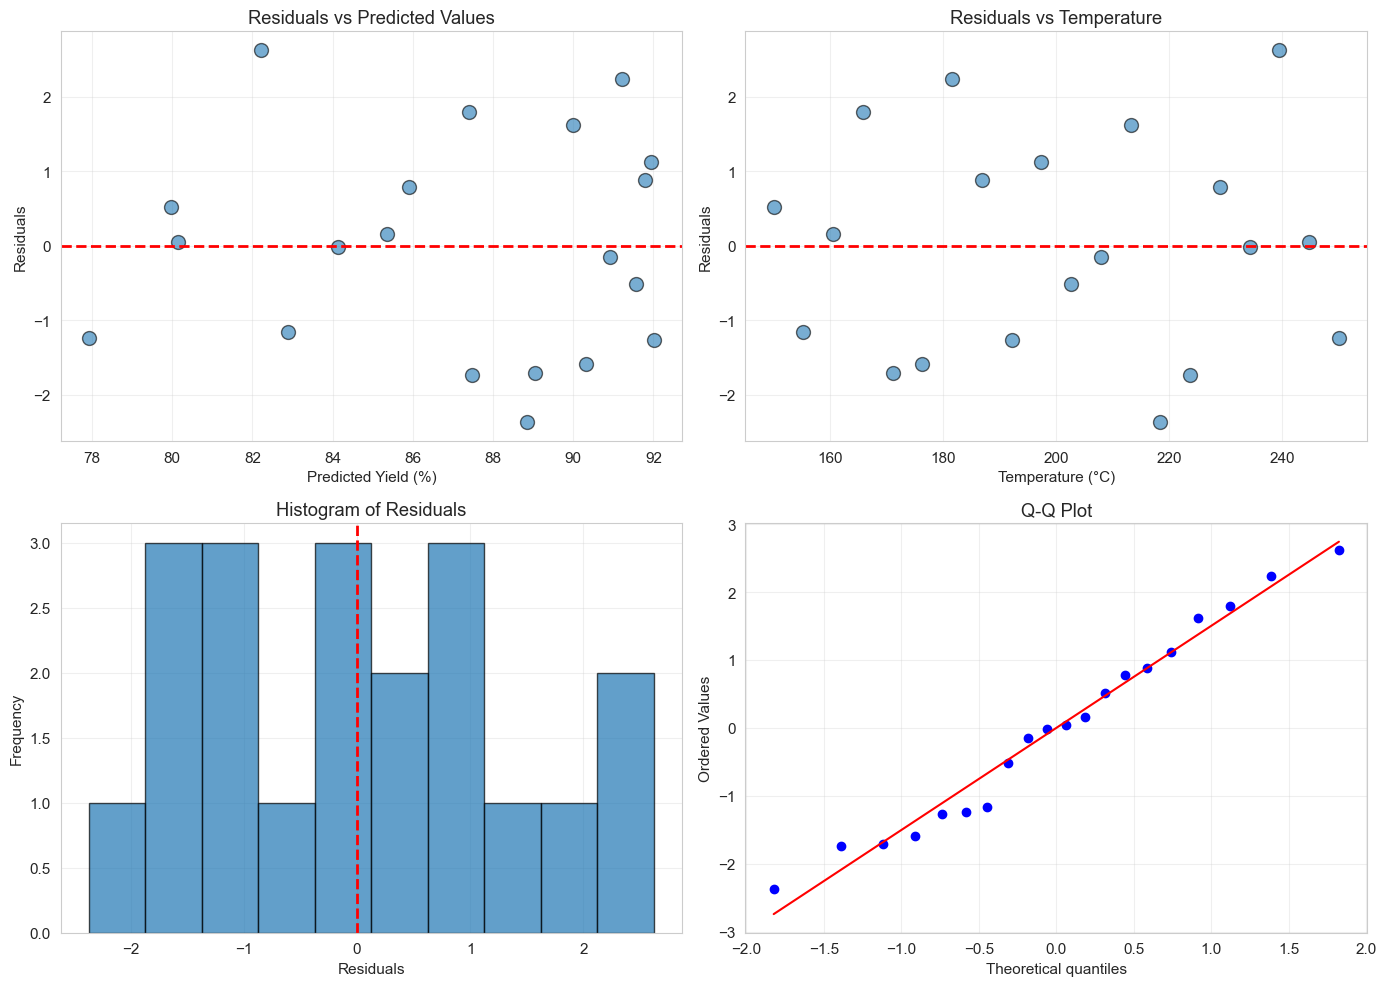

✓ 圖檔已儲存


In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 殘差 vs 預測值
axes[0, 0].scatter(y_pred_final, residuals, alpha=0.6, s=100, edgecolors='black')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Yield (%)')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted Values')
axes[0, 0].grid(True, alpha=0.3)

# 殘差 vs 溫度
axes[0, 1].scatter(X, residuals, alpha=0.6, s=100, edgecolors='black')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Temperature')
axes[0, 1].grid(True, alpha=0.3)

# 殘差直方圖
axes[1, 0].hist(residuals, bins=10, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q 圖
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '07_residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 圖檔已儲存")

---
## 8. 比較不同正則化方法

In [18]:
# 使用較高次數 (degree=3) 比較正則化效果
test_degree = 3

regularization_models = {
    'No Regularization': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=10.0)': Ridge(alpha=10.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
    'Lasso (α=1.0)': Lasso(alpha=1.0)
}

reg_results = []

print(f"\n比較不同正則化方法 (Polynomial Degree = {test_degree}):")
print("=" * 70)

for name, reg in regularization_models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=test_degree)),
        ('regressor', reg)
    ])
    
    # 訓練
    pipeline.fit(X_train, y_train)
    
    # 預測
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    # 評估
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    reg_results.append({
        'Method': name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse
    })
    
    print(f"{name:25s}: Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}, RMSE = {test_rmse:.2f}")

reg_results_df = pd.DataFrame(reg_results)
print("\n" + reg_results_df.to_string(index=False))


比較不同正則化方法 (Polynomial Degree = 3):
No Regularization        : Train R² = 0.9366, Test R² = 0.6278, RMSE = 2.22
Ridge (α=1.0)            : Train R² = 0.9175, Test R² = 0.6941, RMSE = 2.01
Ridge (α=10.0)           : Train R² = 0.7586, Test R² = -0.6113, RMSE = 4.61
Lasso (α=0.1)            : Train R² = 0.9285, Test R² = 0.7274, RMSE = 1.90
Lasso (α=1.0)            : Train R² = 0.7649, Test R² = -0.1889, RMSE = 3.96

           Method  Train_R2   Test_R2  Test_RMSE
No Regularization  0.936595  0.627815   2.216319
    Ridge (α=1.0)  0.917461  0.694083   2.009344
   Ridge (α=10.0)  0.758575 -0.611274   4.611449
    Lasso (α=0.1)  0.928517  0.727369   1.896881
    Lasso (α=1.0)  0.764932 -0.188858   3.961118


---
## 9. 總結與建議

### 9.1 分析結果

1. **最佳多項式次數**：{best_degree}
   - 在該次數下，模型達到最佳的偏差-變異平衡
   - 交叉驗證 R² 分數最高

2. **最佳操作條件**：
   - 最佳反應溫度：約 {optimal_temp:.1f}°C
   - 預測最大產率：約 {optimal_yield:.1f}%

3. **模型表現**：
   - 較低次數（degree=1）：欠擬合，無法捕捉曲線關係
   - 適中次數（degree=2-3）：擬合良好，泛化能力強
   - 較高次數（degree≥4）：可能過擬合，在邊界處不穩定

### 9.2 實務建議

- 對於此類拋物線關係，**二次多項式**通常足夠且最穩定
- 必須對特徵進行**標準化**以避免數值問題
- 使用**交叉驗證**選擇最佳次數，避免過擬合
- 避免在訓練資料範圍外（150-250°C）進行預測
- 高次多項式應搭配**正則化**（Ridge 或 Lasso）

### 9.3 後續改進方向

- 收集更多實驗資料以提升模型精度
- 考慮多變數情況（溫度 + 壓力 + 催化劑濃度）
- 嘗試其他非線性模型（決策樹、隨機森林、SVR）
- 結合化學動力學模型進行混合建模

---
## 10. 儲存結果

In [19]:
# 儲存評估結果
results_df.to_csv(OUTPUT_DIR / 'polynomial_regression_results.csv', index=False)
print(f"✓ 評估結果已儲存至: {OUTPUT_DIR / 'polynomial_regression_results.csv'}")

# 儲存預測結果
prediction_df.to_csv(OUTPUT_DIR / 'temperature_yield_predictions.csv', index=False)
print(f"✓ 預測結果已儲存至: {OUTPUT_DIR / 'temperature_yield_predictions.csv'}")

# 儲存最佳操作條件
optimal_conditions = pd.DataFrame({
    'Parameter': ['Optimal Temperature (°C)', 'Maximum Yield (%)'],
    'Value': [optimal_temp, optimal_yield]
})
optimal_conditions.to_csv(OUTPUT_DIR / 'optimal_operating_conditions.csv', index=False)
print(f"✓ 最佳操作條件已儲存至: {OUTPUT_DIR / 'optimal_operating_conditions.csv'}")

print("\n" + "="*70)
print("所有結果已儲存完成！")
print("="*70)

✓ 評估結果已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Polynomial_Regression\polynomial_regression_results.csv
✓ 預測結果已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Polynomial_Regression\temperature_yield_predictions.csv
✓ 最佳操作條件已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Polynomial_Regression\optimal_operating_conditions.csv

所有結果已儲存完成！
